In [1]:
import veloxchem as vlx
import numpy as np
from matplotlib import pyplot as plt

h2o_xyz = """3
water                                                                                                                          
O    0.000000000000        0.000000000000        0.000000000000                         
H    0.000000000000        0.895700000000       -0.316700000000                         
H    0.000000000000        0.000000000000        1.100000000000
"""

mol = vlx.Molecule.from_xyz_string(h2o_xyz)

basis = vlx.MolecularBasis.read(mol, "cc-pvdz")

scfdrv = vlx.ScfRestrictedDriver()
scfdrv.compute(mol, basis)

                                                                                                                          
                                            Self Consistent Field Driver Setup                                            
                                                                                                                          
                   Wave Function Model             : Spin-Restricted Hartree-Fock                                         
                   Initial Guess Model             : Superposition of Atomic Densities                                    
                   Convergence Accelerator         : Two Level Direct Inversion of Iterative Subspace                     
                   Max. Number of Iterations       : 50                                                                   
                   Max. Number of Error Vectors    : 10                                                                   
                

In [2]:
epsilon = scfdrv.scf_tensors["E"]
C = scfdrv.scf_tensors["C"]
moeridrv = vlx.MOIntegralsDriver()
eri_oovv = moeridrv.compute_in_mem(mol, basis, mol_orbs=scfdrv.mol_orbs, mints_type="OOVV")
N_O = mol.number_of_electrons() // 2
N_V = scfdrv.mol_orbs.number_mos() - N_O

The MP2 t-amplitudes are defined as:
\begin{align}
t_{ijab} = \frac{\langle ij || ab \rangle}{\epsilon_a + \epsilon_b - \epsilon_i - \epsilon_j} = \frac{\langle ij | ab \rangle - \langle ij | ba \rangle}{\epsilon_a + \epsilon_b - \epsilon_i - \epsilon_j}
\end{align}

In [3]:
def get_t_amplitudes(eri_oovv, epsilon, N_O, N_V, restricted=True):
    if restricted:
        #t_aaaa, t_abab, t_abba
        #t_bbbb, t_baba, t_baab
        # extract the occupied subset of the orbital energies
        e_ij = epsilon[:N_O]
        # extract the virtual subset of the orbital energies
        e_ab = epsilon[N_O:]

        t_aaaa = np.zeros((N_O, N_O, N_V, N_V))
        t_abab = np.zeros((N_O, N_O, N_V, N_V))
        t_abba = np.zeros((N_O, N_O, N_V, N_V))
        for i in range(N_O):
            for j in range(N_O):
                for a in range(N_V):
                    for b in range(N_V):
                        # energy denominators
                        e_ijab = e_ab[a] + e_ab[b] - e_ij[i] - e_ij[j] 
                    
                        # calculate the t-amplitudes for different spin-blocks
                        t_aaaa[i,j,a,b] = (eri_oovv[i, j, a, b] - eri_oovv[i, j, b, a]) / e_ijab
                        t_abab[i,j,a,b] = eri_oovv[i, j, a, b] / e_ijab
                        t_abba[i,j,a,b] = - eri_oovv[i, j, b, a] / e_ijab
                        
                        
        t_mp2 = [t_aaaa, t_abab, t_abba]
        return t_mp2
        

In [4]:
def get_mp2_correction(eri_oovv, epsilon, N_O, N_V):
    e_mp2_ss = 0.0
    e_mp2_os = 0.0

    # extract the occupied subset of the orbital energies
    e_ij = epsilon[:N_O]
    # extract the virtual subset of the orbital energies
    e_ab = epsilon[N_O:]

    for i in range(N_O):
        for j in range(N_O):
            for a in range(N_V):
                for b in range(N_V):
                    # energy denominators
                    e_ijab = e_ab[a] + e_ab[b] - e_ij[i] - e_ij[j] 
                    
                    # update opposite-spin component of the energy
                    e_mp2_os -= (eri_oovv[i, j, a, b] * eri_oovv[i, j, a, b]) / e_ijab
                    
                    # update same-spin component of the energy
                    e_mp2_ss -= eri_oovv[i, j, a, b] * (eri_oovv[i, j, a, b]  - eri_oovv[i, j, b, a]) / e_ijab
    return e_mp2_ss, e_mp2_os

In [5]:
e_mp2_ss, e_mp2_os = get_mp2_correction(eri_oovv, epsilon, N_O, N_V)

In [6]:
print(f"Opposite-spin MP2 energy: {e_mp2_os:20.12f}")
print(f"Same-spin MP2 energy:     {e_mp2_ss:20.12f}")
print(f"MP2 energy:               {e_mp2_os + e_mp2_ss:20.12f}")

Opposite-spin MP2 energy:      -0.156069692110
Same-spin MP2 energy:          -0.052034742444
MP2 energy:                    -0.208104434554


The MP2 energy correction can be calculated as:
\begin{equation}
E_\textrm{MP2} = -\frac14\sum_{i,j,a,b}t_{ijab}\langle ij || ab \rangle = -\frac14\sum_{i,j,a,b}t_{ijab}(\langle ij | ab \rangle - \langle ij | ba \rangle)
\end{equation}

In [7]:
t2 = get_t_amplitudes(eri_oovv, epsilon, N_O, N_V)

In [8]:
E_mp2 = -0.5*( np.einsum('ijab,ijab->', t2[0], eri_oovv)
          -np.einsum('ijab,ijba->', t2[0], eri_oovv)
          +np.einsum('ijab,ijab->', t2[1], eri_oovv)
          -np.einsum('ijab,ijba->', t2[2], eri_oovv) )
print(E_mp2)

-0.2081044345538065


In [9]:
print(t2[0].shape)

(5, 5, 19, 19)


## O-H Dissociation Potential Energy Curve

In [10]:
mol_template = """                                                                                                              
O    0.000000000000        0.000000000000        0.000000000000                         
H    0.000000000000        0.895700000000       -0.316700000000                         
H    0.000000000000        0.000000000000        OHdist
"""

In [11]:
scfdrv.max_iter = 100

In [12]:
distlist = [0.7,0.75,0.8,0.85,0.9,0.95,1.0,1.05,1.1,1.3,1.5,1.7,2,2.5,3,3.4,4.1,4.5]
#distlist=[0.7,0.8,0.9,0.95,1.1,1.3,1.5,1.7,2,2.5,3,4,5]
E_hf = []
E_mp2 = []
#scfdrv.ostream.state = False # To disable the printout
for oh in distlist:
    print("Calculating the energies for... ", oh)
    mol_str = mol_template.replace("OHdist", str(oh))
    molecule = vlx.Molecule.read_str(mol_str, units='angstrom')
    basis = vlx.MolecularBasis.read(molecule,"cc-pvdz")
    scfdrv.compute(molecule, basis)
    E_hf.append(scfdrv.get_scf_energy())
    eri_oovv = moeridrv.compute_in_mem(molecule, basis, mol_orbs=scfdrv.mol_orbs, mints_type="OOVV")
    epsilon = scfdrv.scf_tensors['E']
    e_mp2_ss, e_mp2_os = get_mp2_correction(eri_oovv, epsilon, N_O, N_V)
    E_mp2.append(scfdrv.get_scf_energy() + e_mp2_ss + e_mp2_os)

Calculating the energies for...  0.7
                                                                                                                          
                                            Self Consistent Field Driver Setup                                            
                                                                                                                          
                   Wave Function Model             : Spin-Restricted Hartree-Fock                                         
                   Initial Guess Model             : Superposition of Atomic Densities                                    
                   Convergence Accelerator         : Two Level Direct Inversion of Iterative Subspace                     
                   Max. Number of Iterations       : 100                                                                  
                   Max. Number of Error Vectors    : 10                                               

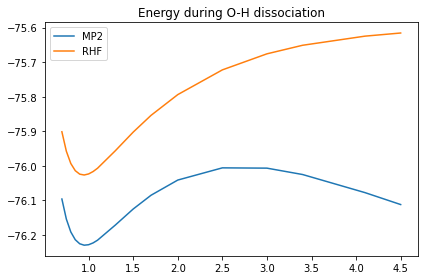

In [13]:
plt.figure(figsize=(6,4))
plt.title('Energy during O-H dissociation')
# x = np.array(distlist[:-1])
# y = np.array(E_mp2[:-1])
# z = np.array(E_hf[:-1])
x = np.array(distlist)
y = np.array(E_mp2)
z = np.array(E_hf)
plt.plot(x,y, label='MP2')
plt.plot(x,z, label='RHF')
plt.legend()
plt.tight_layout(); plt.show()

In [10]:
# Show FCI reference curve
# Adapt the routine to also handle unrestricted calculations and be able to compute the MP2 correction for H and OH,
# to be able to directly compare to the MCSCF notebook

## Dipole moment

In [14]:
molecule = vlx.Molecule.from_xyz_string(h2o_xyz)

basis = vlx.MolecularBasis.read(molecule, "cc-pvdz")

scfdrv = vlx.ScfRestrictedDriver()
scfdrv.compute(molecule, basis)

                                                                                                                          
                                            Self Consistent Field Driver Setup                                            
                                                                                                                          
                   Wave Function Model             : Spin-Restricted Hartree-Fock                                         
                   Initial Guess Model             : Superposition of Atomic Densities                                    
                   Convergence Accelerator         : Two Level Direct Inversion of Iterative Subspace                     
                   Max. Number of Iterations       : 50                                                                   
                   Max. Number of Error Vectors    : 10                                                                   
                

### HF Dipole Moment

In [17]:
scf_tensors = scfdrv.scf_tensors
density = scf_tensors['D_alpha'] + scf_tensors['D_beta'] 
prop = vlx.firstorderprop.FirstOrderProperties() 
prop.compute(molecule, basis, hf_den)
hf_dipole_moment = prop.get_property('dipole moment')
prop.print_properties(molecule, 'HF dipole moment')
#print("This is the HF dipole moment of the water molecule: [%.2f, %.2f, %.2f] a.u.", hf_dipole_moment )

                                                                                                                          
                                                     HF dipole moment                                                     
                                                    ------------------                                                    
                                                                                                                          
                                   X   :        -0.000000 a.u.        -0.000000 Debye                                     
                                   Y   :         0.627759 a.u.         1.595605 Debye                                     
                                   Z   :         0.498105 a.u.         1.266056 Debye                                     
                                 Total :         0.801368 a.u.         2.036873 Debye                                     
                

### MP2 Unrelaxed Dipole Moment

### Numerical MP2 Dipole Moment

### Approximate MP2 Dipole Moment (Expectation value)